# キレイなプロット

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 20 # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.labelsize'] = 17 # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 17 # 軸だけ変更されます
plt.rcParams['xtick.direction'] = 'in' # x axis in
plt.rcParams['ytick.direction'] = 'in' # y axis in 
plt.rcParams['axes.linewidth'] = 1.0 # axis line width
plt.rcParams['axes.grid'] = True # make grid

# Robustness Plot

In [3]:
def make_heatmap(dataset_name, resize, model_name="CNN", plot=True):
    # load df
    ba = pd.read_csv(f"./robustness_plot/acc_df/{model_name}_BA_{dataset_name}_{resize}.csv", index_col=0)
    attach = pd.read_csv(f"./robustness_plot/acc_df/{model_name}_Attach_{dataset_name}_{resize}.csv", index_col=0)
    growth = pd.read_csv(f"./robustness_plot/acc_df/{model_name}_Growth_{dataset_name}_{resize}.csv", index_col=0)
    random = pd.read_csv(f"./robustness_plot/acc_df/{model_name}_Random_{dataset_name}_{resize}.csv", index_col=0)
    
    # plot
    fig, axes = plt.subplots(1,4, figsize=(20,5))
    sns.heatmap(ba, cmap="plasma", cbar=False, ax=axes[0], vmin=0,vmax=1)
    sns.heatmap(attach, cmap="plasma", cbar=False, ax=axes[1], vmin=0,vmax=1)
    sns.heatmap(growth, cmap="plasma", cbar=False, ax=axes[2], vmin=0,vmax=1)
    sns.heatmap(random, cmap="plasma", cbar=False, ax=axes[3], vmin=0,vmax=1)
    ## title
    axes[0].set_title("BA")
    axes[1].set_title("Attach")
    axes[2].set_title("Growth")
    axes[3].set_title("Random")
    ## lable
    for i in range(4):
        axes[i].set_xlabel("node")
        axes[i].set_ylabel("parameter")

    plt.subplots_adjust(wspace=.02, hspace=0.)
    plt.tight_layout()
    plt.savefig(f"./robustness_plot/heatmap/{model_name}_{dataset_name}_{resize}.png", dpi=300)
    if not plot:
        plt.close()

In [4]:
name_list = ["subset1", "poisson", "new_poisson", "new_parete"]
resize_list = [100]
model_name_list = ["Deepsets"]

for model_name in model_name_list:
    for name in name_list:
        for resize in resize_list:
            print(model_name, name, resize)
            make_heatmap(name, resize, model_name=model_name, plot=False)

Deepsets subset1 100
Deepsets poisson 100
Deepsets new_poisson 100
Deepsets new_parete 100


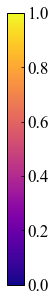

In [99]:
# colorbar
fig, ax = plt.subplots(figsize=(.3,5))
norm = colors.Normalize(vmin=0,vmax=1)
mappable = ScalarMappable(cmap='plasma',norm=norm)
mappable._A = []
fig.colorbar(mappable, cax=ax)
plt.savefig("./robustness_plot/heatmap/color_bar.png", dpi=300, bbox_inches='tight')

# 重ねたい (ヒートマップと訓練データの分布)

In [12]:
def load_acc_df(dataset, kind, model_name, resize):
    # heatmap df の読み込み
    df = pd.read_csv(f"./robustness_plot/acc_df/{model_name}_{kind}_{dataset}_{resize}.csv")
    df.index = df["Unnamed: 0"]
    df.drop("Unnamed: 0", axis=1, inplace=True)
    # column(ノード数)を整数型に変換
    df.rename(columns={i: int(i) for i in df.columns}, inplace=True)
    if kind == "Attach":
        k = {index: index.replace("node*", "") for index in df.index}
        k["node"] = 1
        df.rename(index={key: float(v) for key, v in k.items()}, inplace=True)
    else:
        df.rename(index={v: float(v) for v in df.index}, inplace=True)
    return df

def make_train_kde(dataset_name,kind,ax):
    # 訓練データの情報
    train_df = pd.read_csv(f"../graph_data/{dataset_name}/data_info.csv")
    train_df.drop("Unnamed: 0", axis=1, inplace=True)
    # 訓練データから対象ネットワークだけ抽出
    q = train_df.query("kind==@kind")
    # ノード数、パラメータでグルーピング
    count_df = q.groupby(["node", "parameter"]).count()
    return q

#     if kind == "Attach":
#         mag = q.parameter.copy() / q.node.copy()
#         q["magnification"] = list(mag)
#         # train dist
#         sns.kdeplot(x=q.node, y=q.magnification, cmap="plasma",
#                     shade=True,bw_adjust=5, ax=ax)
#     else:
#         sns.kdeplot(x=q.node, y=q.parameter, cmap="plasma",
#                         shade=True,bw_adjust=5,ax=ax)


In [5]:

# fig = plt.figure(figsize=(28,16))
# gs = gridspec.GridSpec(4, 7)
dataset_name = "subset1"

for dataset_name in ["subset1", "poisson", "new_poisson", "new_parete"]:
    fig, axes = plt.subplots(4,6,figsize=(28,16), sharex=True)
    for row, kind in enumerate(["BA", "Attach", "Growth", "Random"]):
        for i, resize in enumerate([50, 100, 200]):
            if row == 0:
                axes[row,i].set_title(f"CNN resize={resize}")
            df = load_acc_df(dataset_name, kind, "CNN", resize)
            # robustness
            axes[row,i].contourf(df.columns, df.index, df.values, cmap="plasma", levels=5)

        for i, model in enumerate(["DGCNN", "GIN", "Deepsets"]):
            if row==0:
                axes[row,i+3].set_title(model)
            df = load_acc_df(dataset_name, kind, model, 100)
            # robustness
            axes[row,i+3].contourf(df.columns, df.index, df.values, cmap="plasma", levels=5)

        for i in range(6):
            axes[row,i].set_xlim(10, 2000)
            axes[row,i].set_ylim(0, max(df.index))
            axes[row,i].set_xscale("log")
            if row == 3:
                axes[row,i].set_xlabel("node")
            if i == 0:
                axes[row,i].set_ylabel(f"{kind} \n paramter")

    plt.tight_layout()
    plt.savefig(f"./robustness_plot/heatmap/{dataset_name}.pdf", dpi=300)
    plt.close()

In [10]:
def make_train_df(dataset_name, kind):
    # 訓練データの情報
    train_df = pd.read_csv(f"../graph_data/{dataset_name}/data_info.csv")
    train_df.drop("Unnamed: 0", axis=1, inplace=True)
    # 訓練データから対象ネットワークだけ抽出
    q = train_df.query("kind==@kind")
    # ノード数、パラメータでグルーピング
    count_df = q.groupby(["node", "parameter"]).count()
    if kind == "Attach":
        mag = q.parameter.copy() / q.node.copy()
        q["magnification"] = list(mag)
    return q

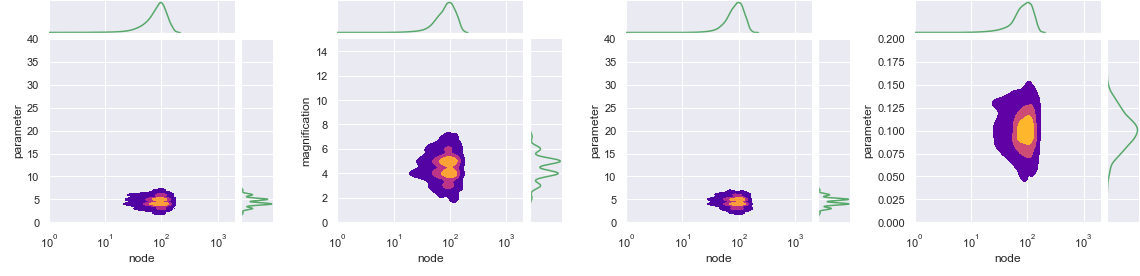

In [33]:

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
import axisgrid as sfg
# An lmplot
dataset_name = "new_poisson"


fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 4)


for i,kind in enumerate(["BA", "Attach", "Growth", "Random"]):
    q=make_train_df(dataset_name, kind)
    if kind == "Attach":
        y="magnification"
        ylim = 15
    else:
        if kind == "Random":
            ylim=0.2
        else:
            ylim=40
        y = "parameter"
    g3 = sns.jointplot("node", y, data=q, shade=True, cmap="plasma",
                       kind="kde", space=0, color="g", levels=4, xlim=(1,2000), ylim=(0,ylim))
    g3.ax_joint.set_xscale('log')
    g3.ax_joint.set_title(kind)
    mg3 = sfg.SeabornFig2Grid(g3, fig, gs[i])

gs.tight_layout(fig)
# gs.update(top=0.7)
plt.savefig(f"./robustness_plot/{dataset_name}.pdf", dpi=300)

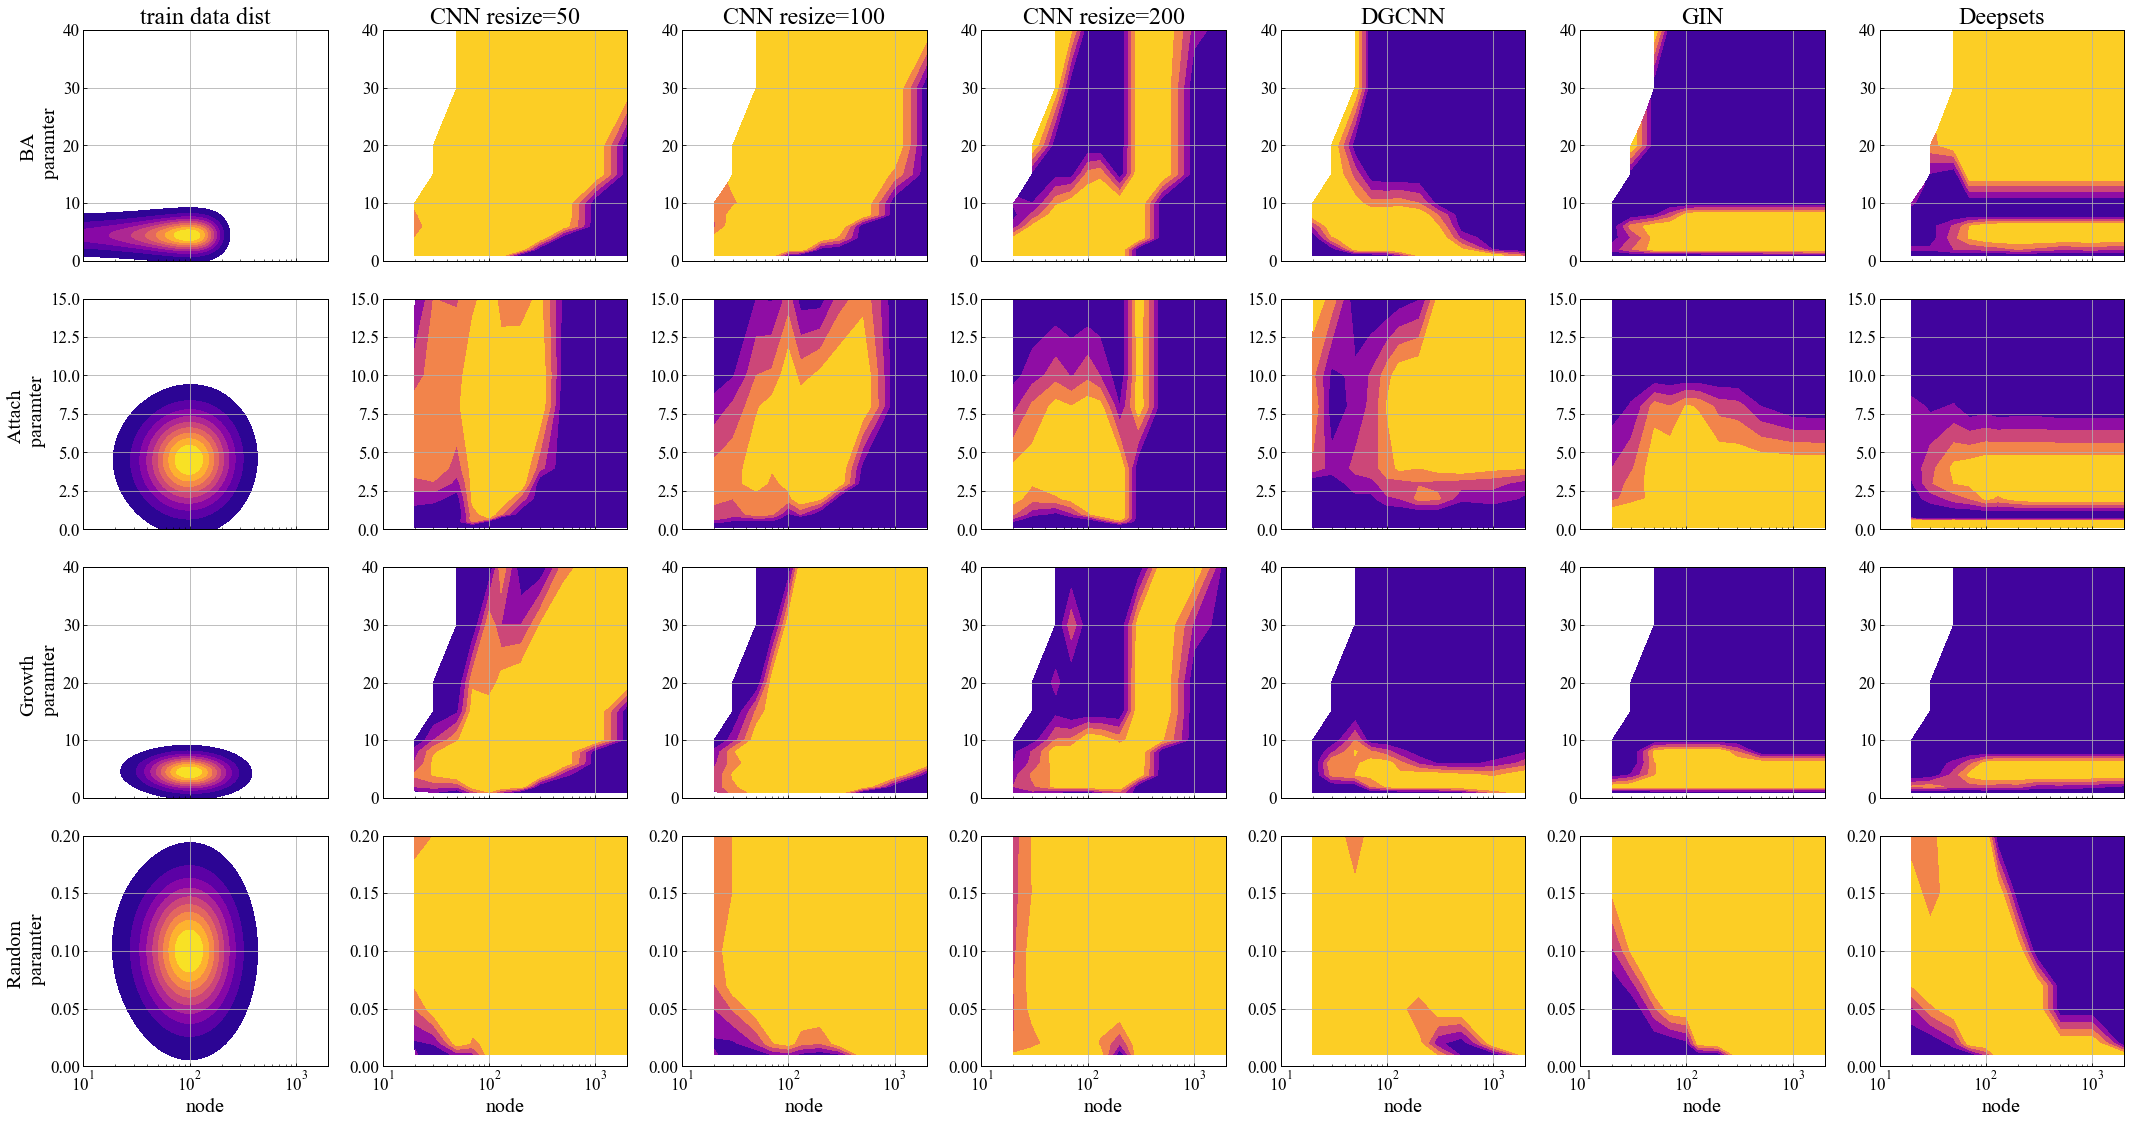

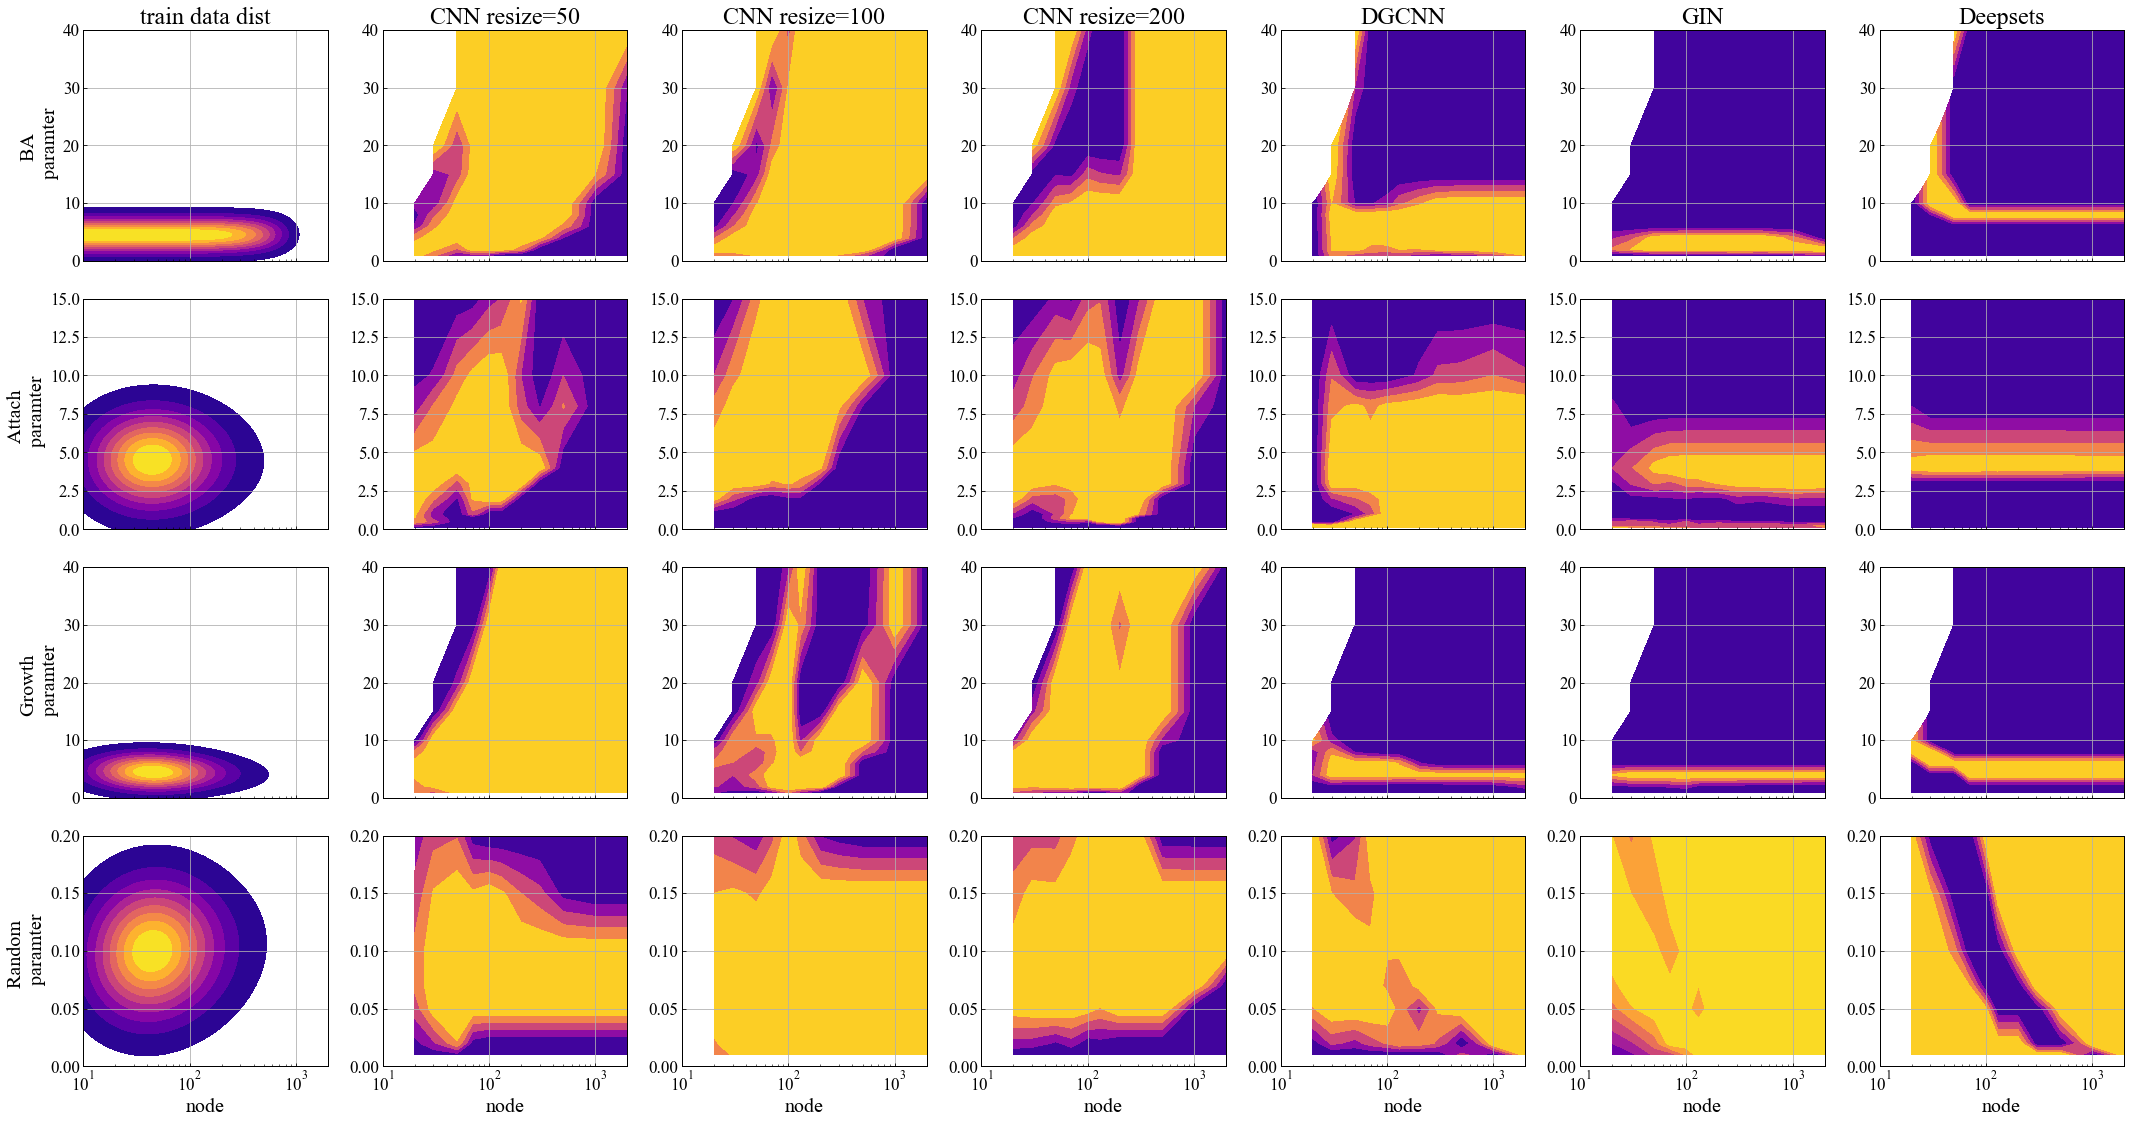

In [14]:

for dataset_name in ["new_poisson", "new_parete"]:
    fig, axes = plt.subplots(4,7,figsize=(30,16), sharex=True)
    for row, kind in enumerate(["BA", "Attach", "Growth", "Random"]):
        if row ==0:
            axes[row,0].set_title("train data dist")
        make_train_kde(dataset_name,kind,axes[row,0])
        for i, resize in enumerate([50, 100, 200]):
            if row == 0:
                axes[row,i+1].set_title(f"CNN resize={resize}")
            df = load_acc_df(dataset_name, kind, "CNN", resize)
            # robustness
            axes[row,i+1].contourf(df.columns, df.index, df.values, cmap="plasma", levels=5)

        for i, model in enumerate(["DGCNN", "GIN", "Deepsets"]):
            if row==0:
                axes[row,i+4].set_title(model)
            df = load_acc_df(dataset_name, kind, model, 100)
            # robustness
            axes[row,i+4].contourf(df.columns, df.index, df.values, cmap="plasma", levels=5)

        for i in range(7):
            axes[row,i].set_xlim(10, 2000)
            axes[row,i].set_ylim(0, max(df.index))
            axes[row,i].set_xscale("log")
            if row == 3:
                axes[row,i].set_xlabel("node")
            if i == 0:
                axes[row,i].set_ylabel(f"{kind} \n paramter")

    plt.tight_layout()
    plt.savefig(f"./robustness_plot/heatmap/{dataset_name}.pdf", dpi=300)
    plt.show()

In [13]:
make_train_kde(dataset_name,kind,axes[row,i])

,average,edges,max_degree,min_degree,Skewness,Kurtosis,average_cluster,average_shortest_path,kind,parameter,node,seed
0,9.691176,659.0,44.0,2.0,2.435200,6.233406,0.165134,2.335076,BA,5.0,136.0,0.0
1,9.481481,384.0,31.0,5.0,1.734839,2.152045,0.224998,2.127469,BA,5.0,81.0,1.0
2,7.808824,531.0,42.0,3.0,2.873674,9.794144,0.157981,2.481155,BA,4.0,136.0,2.0
3,7.808824,531.0,41.0,4.0,2.790392,9.444336,0.128550,2.499455,BA,4.0,136.0,3.0
4,9.652893,584.0,48.0,5.0,2.643979,9.321958,0.153519,2.296556,BA,5.0,121.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,9.647059,574.0,34.0,5.0,2.049414,3.901169,0.162472,2.304657,BA,5.0,119.0,995.0
996,5.066667,38.0,10.0,2.0,0.753690,-0.824467,0.518995,1.704762,BA,3.0,15.0,996.0
997,11.523077,749.0,50.0,6.0,2.194978,5.613465,0.170371,2.204174,BA,6.0,130.0,997.0
998,11.572414,839.0,44.0,6.0,2.146084,4.327071,0.176951,2.241379,BA,6.0,145.0,998.0


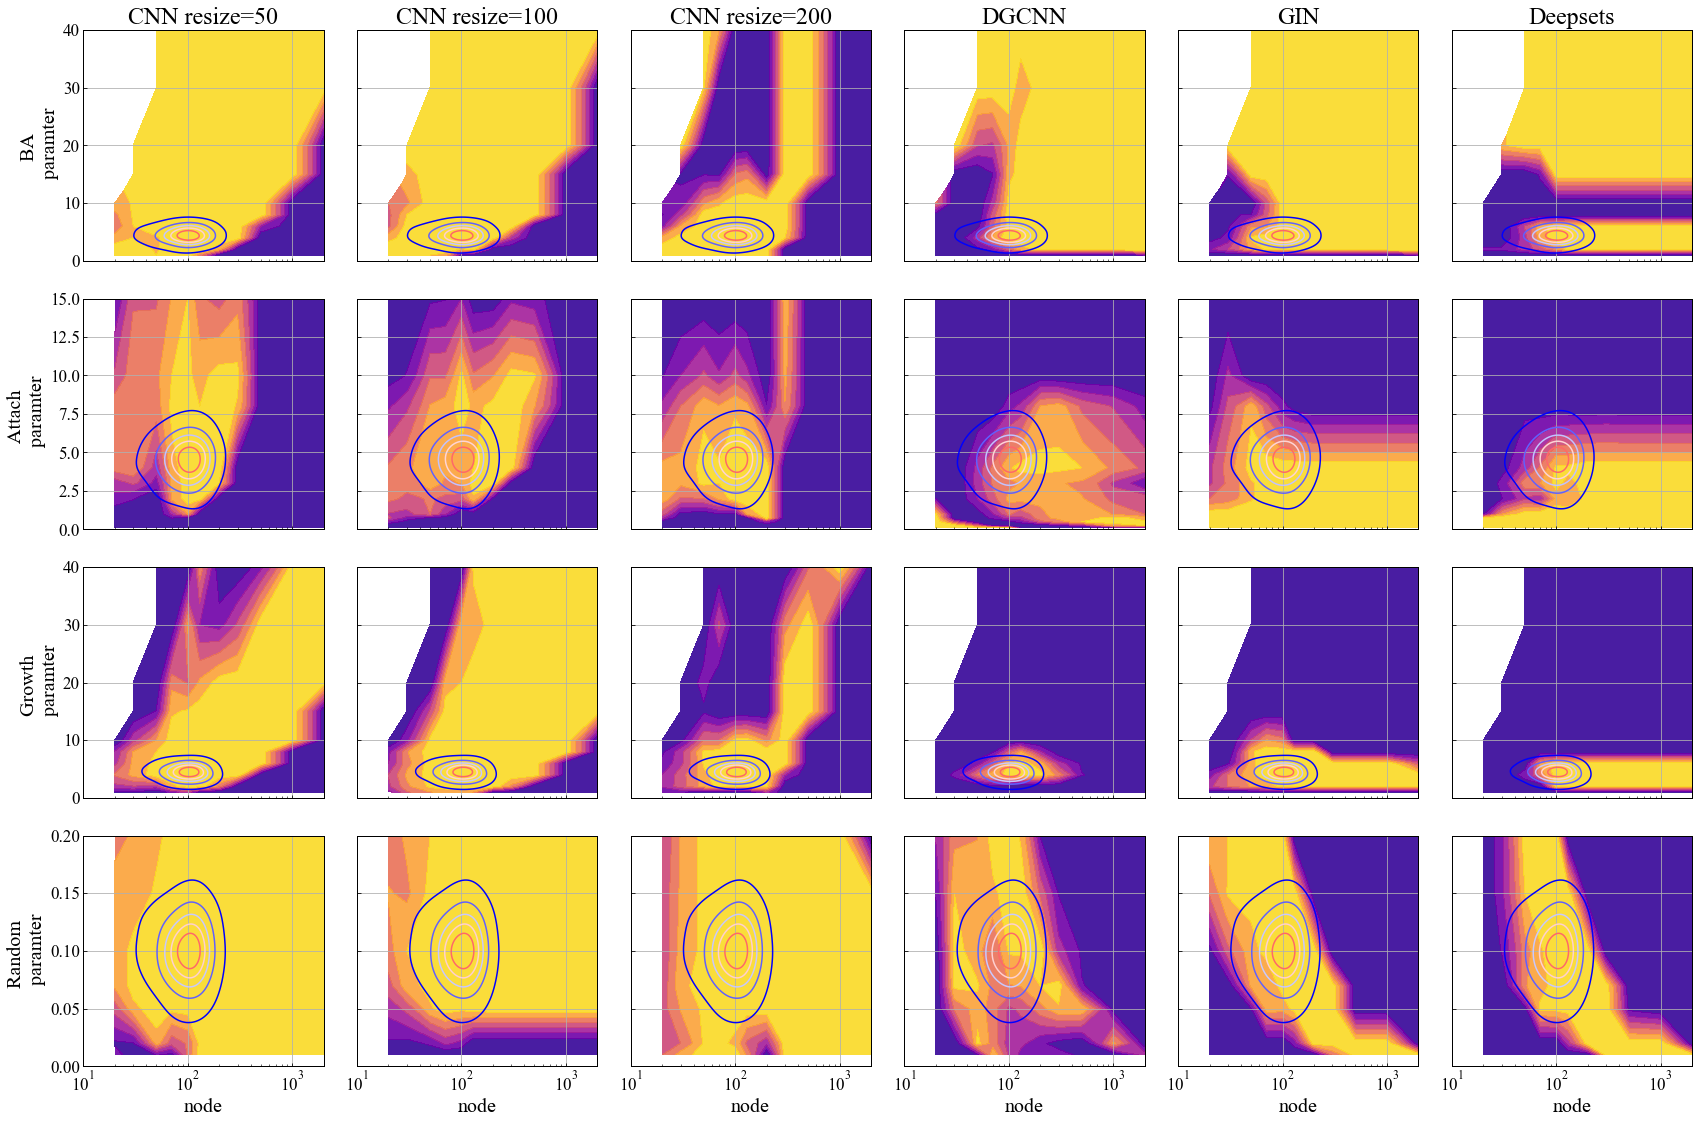

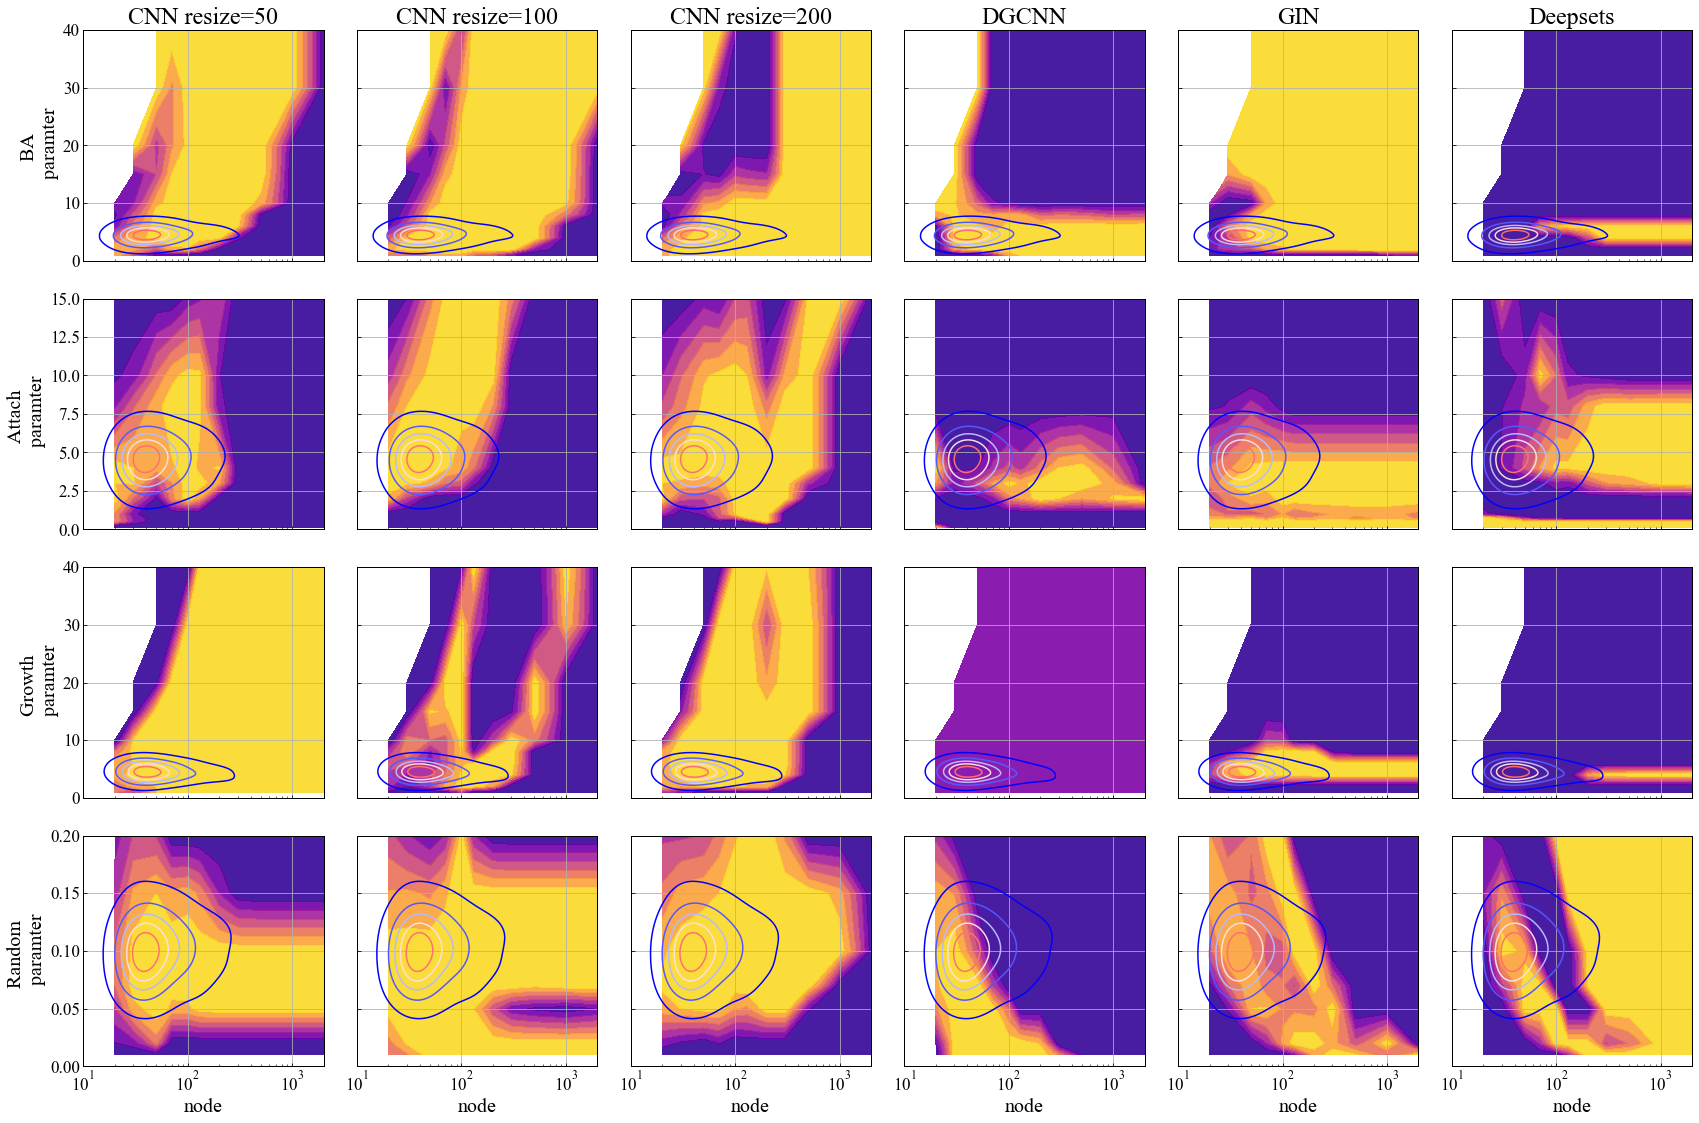

In [16]:
for dataset_name in ["new_poisson", "new_parete"]:
    fig, axes = plt.subplots(4,6,figsize=(24,16), sharex=True)
    for row, kind in enumerate(["BA", "Attach", "Growth", "Random"]):
        
        for i, resize in enumerate([50, 100, 200]):
            if row == 0:
                axes[row,i].set_title(f"CNN resize={resize}")
            df = load_acc_df(dataset_name, kind, "CNN", resize)
            # robustness
            axes[row,i].contourf(df.columns, df.index, df.values, cmap="plasma", levels=6, alpha=.9)

        for i, model in enumerate(["DGCNN", "GIN", "Deepsets"]):
            if row==0:
                axes[row,i+3].set_title(model)
            df = load_acc_df(dataset_name, kind, model, 100)
            # robustness
            axes[row,i+3].contourf(df.columns, df.index, df.values, cmap="plasma", levels=6, alpha=.9)
        
        q = make_train_kde(dataset_name,kind,axes[row,i])
        
        for i in range(6):
            if kind == "Attach":
                sns.kdeplot(x=q.node, y=q.magnification, cmap="bwr",alpha=1, log_scale=(True, False),
                                shade=False, bw_adjust=2, ax=axes[row,i], levels=6)
            else:
                sns.kdeplot(x=q.node, y=q.parameter, cmap="bwr", log_scale=(True, False),
                                shade=False,bw_adjust=2,ax=axes[row,i], alpha=1, levels=6)
            
            axes[row,i].set_xlim(10, 2000)
            axes[row,i].set_ylim(0, max(df.index))
            axes[row,i].set_xscale("log")
            if row == 3:
                axes[row,i].set_xlabel("node")
            if i == 0:
                axes[row,i].set_ylabel(f"{kind} \n paramter")
            else:
                axes[row,i].set_ylabel(None)
                axes[row,i].yaxis.set_ticklabels([])
        
    plt.tight_layout()
    plt.savefig(f"./robustness_plot/heatmap/{dataset_name}.pdf", dpi=300)
    plt.show()

In [15]:
def make_train_kde(dataset_name,kind,ax):
    # 訓練データの情報
    train_df = pd.read_csv(f"../graph_data/{dataset_name}/data_info.csv")
    train_df.drop("Unnamed: 0", axis=1, inplace=True)
    # 訓練データから対象ネットワークだけ抽出
    q = train_df.query("kind==@kind")
    # ノード数、パラメータでグルーピング
    count_df = q.groupby(["node", "parameter"]).count()
    if kind == "Attach":
        mag = q.parameter.copy() / q.node.copy()
        q["magnification"] = list(mag)
        # train dist
#         sns.kdeplot(x=q.node, y=q.magnification, cmap="bwr",alpha=1,
#                     shade=False, bw_adjust=2, ax=ax, levels=6)
#     else:
#         sns.kdeplot(x=q.node, y=q.parameter, cmap="bwr",
#                         shade=False,bw_adjust=2,ax=ax, alpha=1, levels=6)
    return q

In [89]:
def scatter_train_data(kind, ax):
    if kind in ["BA", "Growth", "Attach"]:
        y=2
    else:
        y=0.04
    ax.plot(100, y, marker='.',markersize=18, color="k")

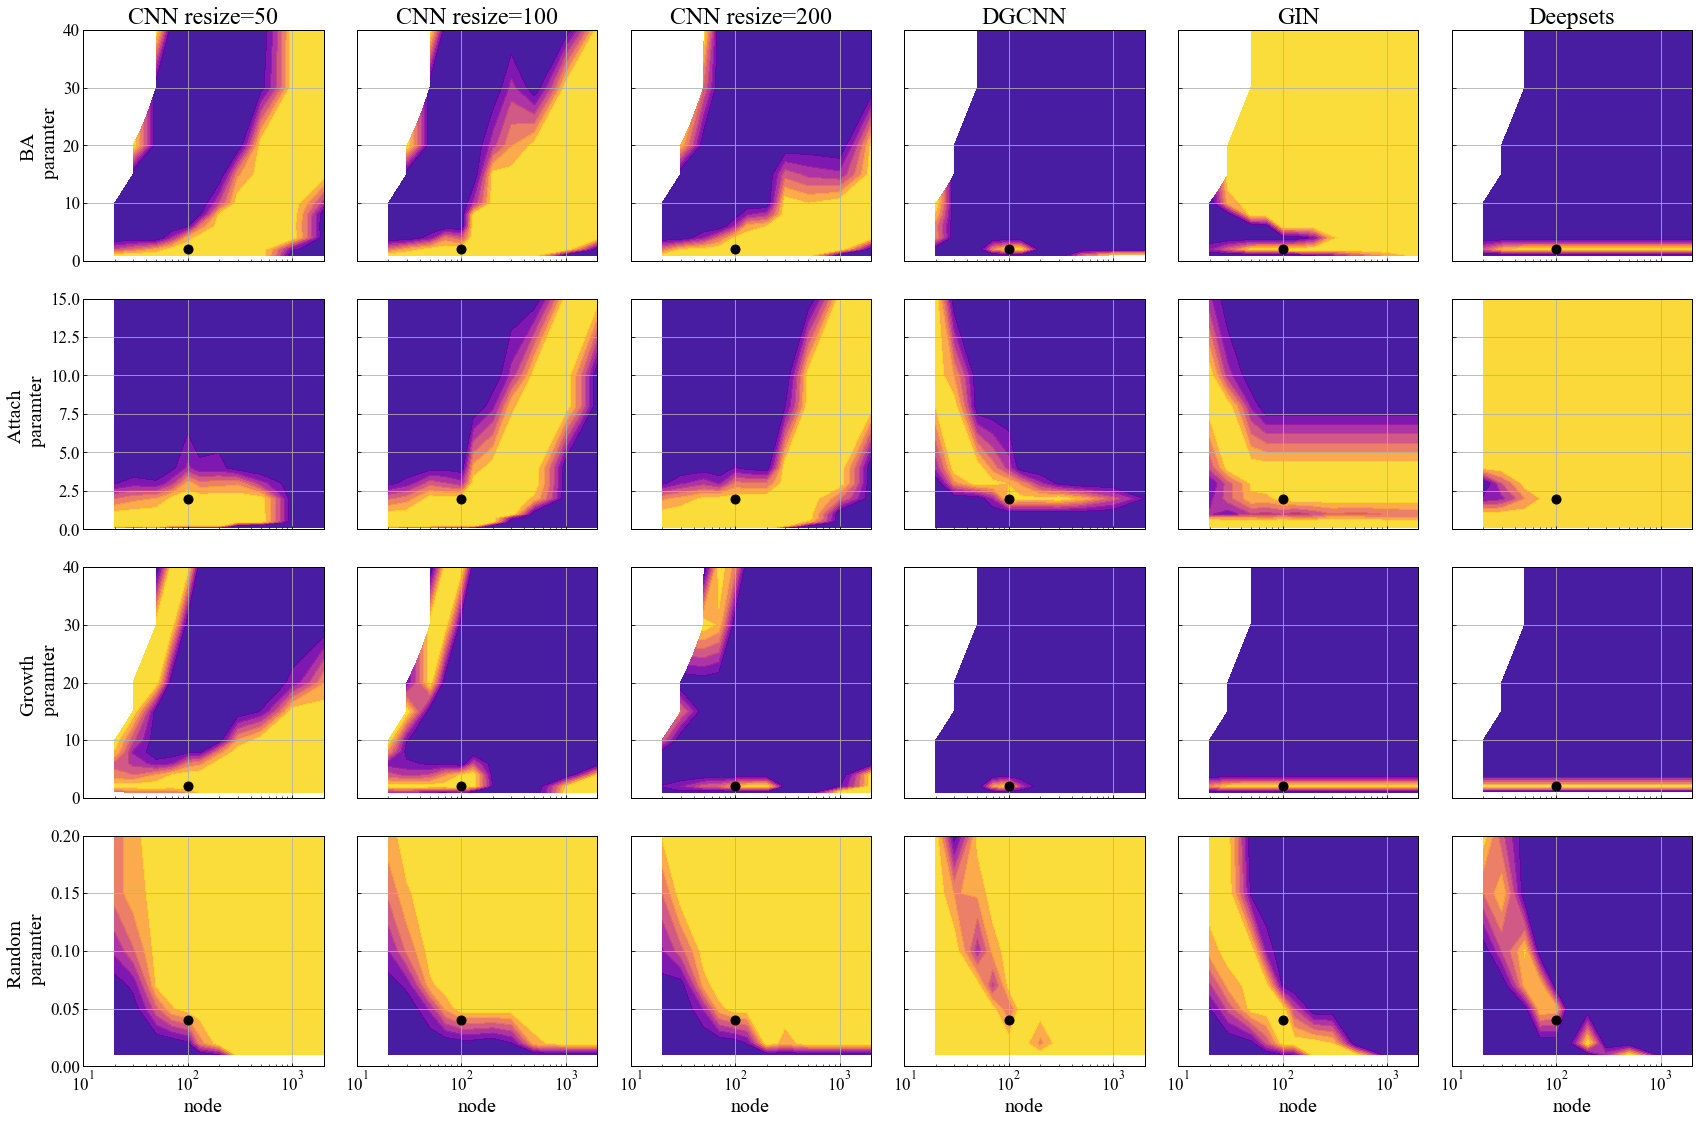

In [91]:
for dataset_name in ["subset1"]:
    fig, axes = plt.subplots(4,6,figsize=(24,16), sharex=True)
    for row, kind in enumerate(["BA", "Attach", "Growth", "Random"]):
        
        for i, resize in enumerate([50, 100, 200]):
            if row == 0:
                axes[row,i].set_title(f"CNN resize={resize}")
            df = load_acc_df(dataset_name, kind, "CNN", resize)
            # robustness
            axes[row,i].contourf(df.columns, df.index, df.values, cmap="plasma", levels=6, alpha=.9)

        for i, model in enumerate(["DGCNN", "GIN", "Deepsets"]):
            if row==0:
                axes[row,i+3].set_title(model)
            df = load_acc_df(dataset_name, kind, model, 100)
            # robustness
            axes[row,i+3].contourf(df.columns, df.index, df.values, cmap="plasma", levels=6, alpha=.9)
        
        
        for i in range(6):
            scatter_train_data(kind, axes[row,i])
            
            axes[row,i].set_xlim(10, 2000)
            axes[row,i].set_ylim(0, max(df.index))
            axes[row,i].set_xscale("log")
            if row == 3:
                axes[row,i].set_xlabel("node")
            if i == 0:
                axes[row,i].set_ylabel(f"{kind} \n paramter")
            else:
                axes[row,i].set_ylabel(None)
                axes[row,i].yaxis.set_ticklabels([])
        
    plt.tight_layout()
    plt.savefig(f"./robustness_plot/heatmap/{dataset_name}.pdf", dpi=300)
    plt.show()

In [177]:
def make_train_kde(dataset_name,kind,ax):
    # 訓練データの情報
    train_df = pd.read_csv(f"../graph_data/{dataset_name}/data_info.csv")
    train_df.drop("Unnamed: 0", axis=1, inplace=True)
    # 訓練データから対象ネットワークだけ抽出
    q = train_df.query("kind==@kind")
    # ノード数、パラメータでグルーピング
    count_df = q.groupby(["node", "parameter"]).count()
    if kind == "Attach":
        mag = q.parameter.copy() / q.node.copy()
        q["magnification"] = list(mag)
        sns.histplot(data=q, x="node", y="magnification", bins=(1,6),ax=ax,cmap="bwr",
                     binwidth=(.1,1),log_scale=(True,False),alpha=.6)
    elif kind=="Random":
        sns.histplot(data=q, x="node", y="parameter", bins=(1,6),ax=ax,cmap="bwr",
                     binwidth=(.1,.02),log_scale=(True,False),alpha=.6)
    else:
        sns.histplot(data=q, x="node", y="parameter", bins=(1,6),ax=ax,cmap="bwr",
                     binwidth=(.1,1),log_scale=(True,False),alpha=.6)
            


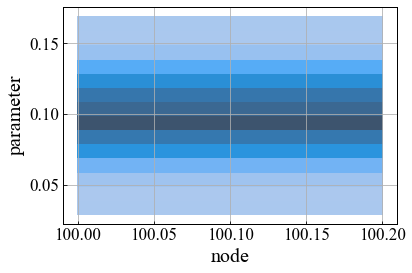

In [178]:
sns.histplot(data=q, x="node", y="parameter", bins=(1,5), binwidth=(.2,.01))

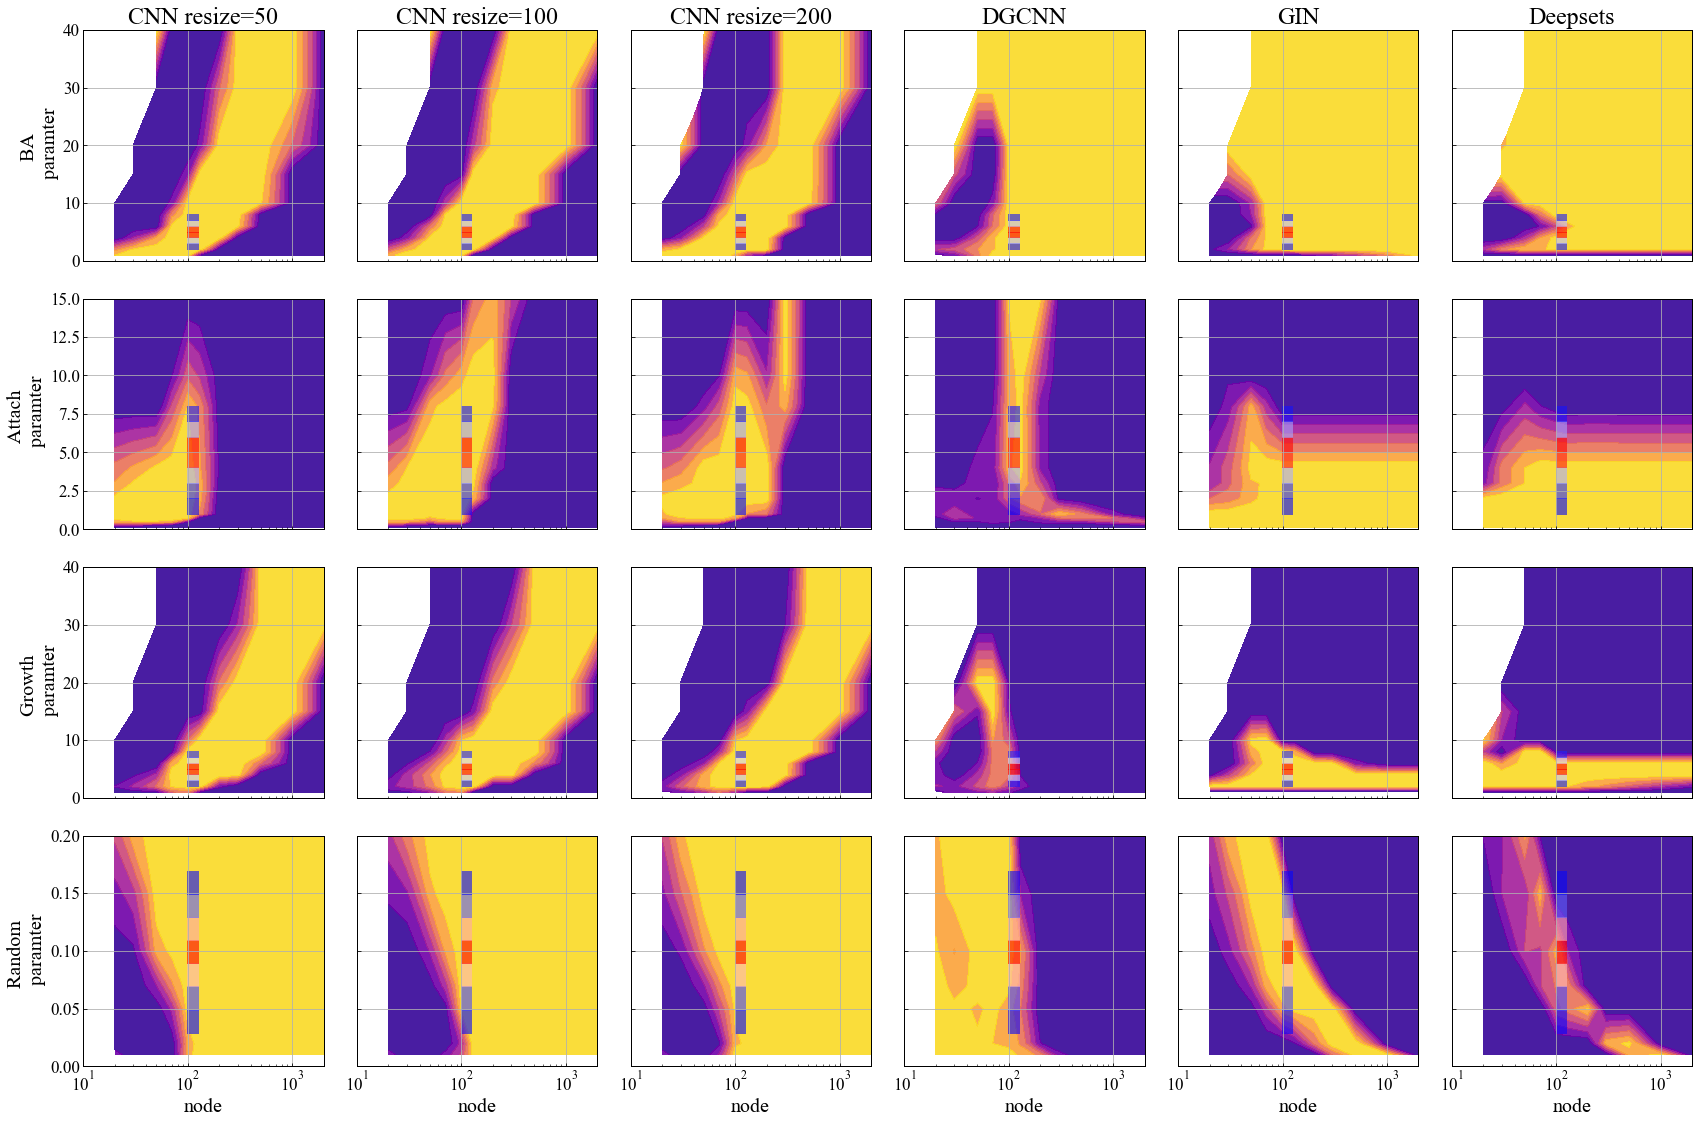

In [179]:
for dataset_name in ["poisson"]:
    fig, axes = plt.subplots(4,6,figsize=(24,16), sharex=True)
    for row, kind in enumerate(["BA", "Attach", "Growth", "Random"]):
        
        for i, resize in enumerate([50, 100, 200]):
            if row == 0:
                axes[row,i].set_title(f"CNN resize={resize}")
            df = load_acc_df(dataset_name, kind, "CNN", resize)
            # robustness
            axes[row,i].contourf(df.columns, df.index, df.values, cmap="plasma", levels=6, alpha=.9)

        for i, model in enumerate(["DGCNN", "GIN", "Deepsets"]):
            if row==0:
                axes[row,i+3].set_title(model)
            df = load_acc_df(dataset_name, kind, model, 100)
            # robustness
            axes[row,i+3].contourf(df.columns, df.index, df.values, cmap="plasma", levels=6, alpha=.9)
        
        
        for i in range(6):
            make_train_kde(dataset_name,kind,axes[row,i])
            
            axes[row,i].set_xlim(10, 2000)
            axes[row,i].set_ylim(0, max(df.index))
            axes[row,i].set_xscale("log")
            if row == 3:
                axes[row,i].set_xlabel("node")
            if i == 0:
                axes[row,i].set_ylabel(f"{kind} \n paramter")
            else:
                axes[row,i].set_ylabel(None)
                axes[row,i].yaxis.set_ticklabels([])
        
    plt.tight_layout()
    plt.savefig(f"./robustness_plot/heatmap/{dataset_name}.pdf", dpi=300)
    plt.show()

# ロバストネス改良

In [326]:
pred_df = pd.read_csv(f"./robustness_plot/DGCNN_subset1_20.csv")

pred_df_c = pd.read_csv(f"./robustness_plot/CNN_subset1_50.csv")

In [323]:
for model in ["DGCNN", "GIN", "Deepsets"]:
    pred_df = pd.read_csv(f"./robustness_plot/{model}_new_poisson_50.csv")
    print(len(pred_df))

43200
43200
43200


In [327]:
len(pred_df)

57600

In [308]:
def merge_df(model, dataset, resize=100, epoch=None):
    if model == "CNN":
        pred_df = pd.read_csv(f"./robustness_plot/{model}_{dataset}_{resize}.csv")
    else:
        pred_df = pd.read_csv(f"./robustness_plot/{model}_{dataset}_{epoch}.csv")
        
    pred_df.drop(["Unnamed: 0", "node", "parameter", "kind"], axis=1, inplace=True)
    pred_df.reset_index(inplace=True)

    robustness_df = pd.read_csv("./robustness_plot/robustness_info.csv")
    robustness_df.drop("Unnamed: 0", axis=1, inplace=True)
    robustness_df.reset_index(inplace=True)

    merge_df = pd.merge(robustness_df, pred_df,left_index=True, right_index=True)
    merge_df.drop(["index_x","index_y"], axis=1, inplace=True)
    
    # edge bins
    edges_bins = []
    for l in pd.cut(merge_df.edges, bins=np.logspace(0, 6.5, num=20)):
        edges_bins.append(float(l.mid))

    merge_df["edges_bins"] = edges_bins
    merge_df[merge_df.probablility < 0.7].pred = -1
    merge_df["correct"] = merge_df["true_label"] == merge_df["pred"]
    
    # grouping
    correct_total = merge_df.groupby(["node", "edges_bins"]).correct.count()
    correct_sum = merge_df.groupby(["node", "edges_bins"]).correct.sum()
    df = pd.DataFrame(correct_sum / correct_total).reset_index()
    q_df = df.pivot_table(index="edges_bins", columns= "node", values="correct")
    
    return q_df

In [309]:
def contour_plot(model, dataset, param, ax):
    if model == "CNN":
        df = merge_df("CNN", dataset, resize=param, epoch=None)
    else:
        df = merge_df(model, dataset, epoch=param)
    
    ax.contourf(df.columns, df.index, df.values, cmap="plasma",
             levels=50, alpha=.9, vmin=0, vmax=1)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim(0, 100000)
    ax.set_xlim(0, 2000)
    
    ax.set_title(f"{dataset} {model} {param}")

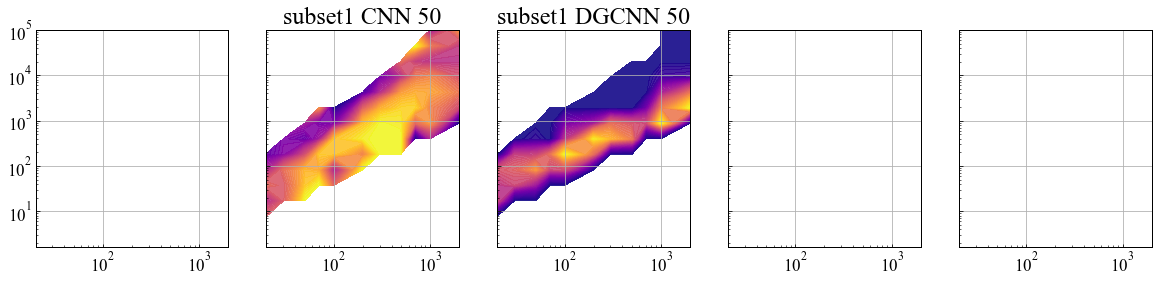

In [312]:
fig, axes = plt.subplots(1,5,figsize=(20,4),sharey=True, sharex=True)
contour_plot("CNN", "subset1", 50, axes[1])
contour_plot("DGCNN", "subset1", 50, axes[2])

In [261]:
# edge bins
edges_bins = []
for l in pd.cut(merge_df.edges, bins=np.logspace(0, 6, num=10)):
    edges_bins.append(float(l.mid))

merge_df["edges_bins"] = edges_bins
merge_df[merge_df.probablility < 0.7].pred = -1
merge_df["correct"] = merge_df["true_label"] == merge_df["pred"]

correct_total = merge_df.groupby(["node", "edges_bins"]).correct.count()
correct_sum = merge_df.groupby(["node", "edges_bins"]).correct.sum()

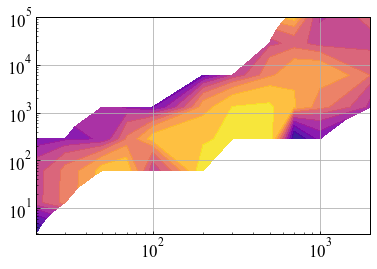

In [263]:
df = pd.DataFrame(correct_sum / correct_total).reset_index()
q_df = df.pivot_table(index="edges_bins", columns= "node", values="correct")
plt.contourf(q_df.columns, q_df.index, q_df.values, cmap="plasma", levels=10, alpha=.9)

plt.yscale("log")
plt.xscale("log")

plt.ylim(0, 100000)
plt.xlim(0, 2000)

plt.show()

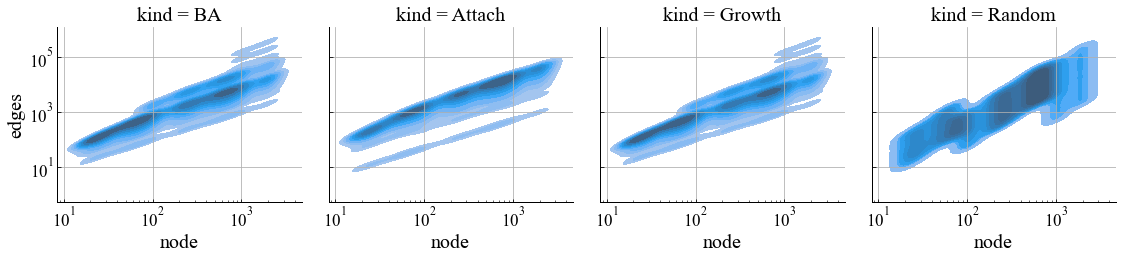

In [88]:
g = sns.FacetGrid(merge_df, col="kind", height=4)
g.map_dataframe(sns.kdeplot, x="node", y="edges",log_scale=(True, True),shade=True, alpha=1)

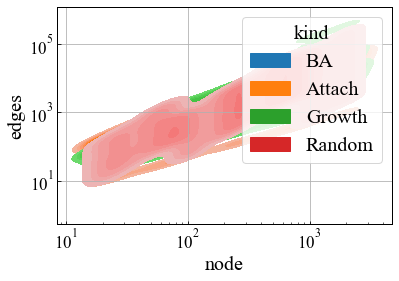

In [86]:
sns.kdeplot(data=merge_df,x="node", y="edges", hue="kind",
            log_scale=(True, True),shade=True, alpha=1)

# 汎化イメージ作成

In [3]:
from reserch_utils_HT import network_to_image
import networkx as nx

In [187]:
G_100 = nx.barabasi_albert_graph(100, 2)
img_100 = network_to_image(G_100, sort=True)

G_2000 = nx.barabasi_albert_graph(1000, 40)
img_2000 = network_to_image(G_2000, sort=True)

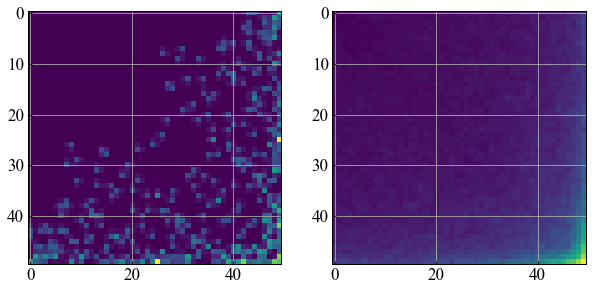

In [192]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(img_100.resize((50,50)))
axes[1].imshow(img_2000.resize((50,50)))

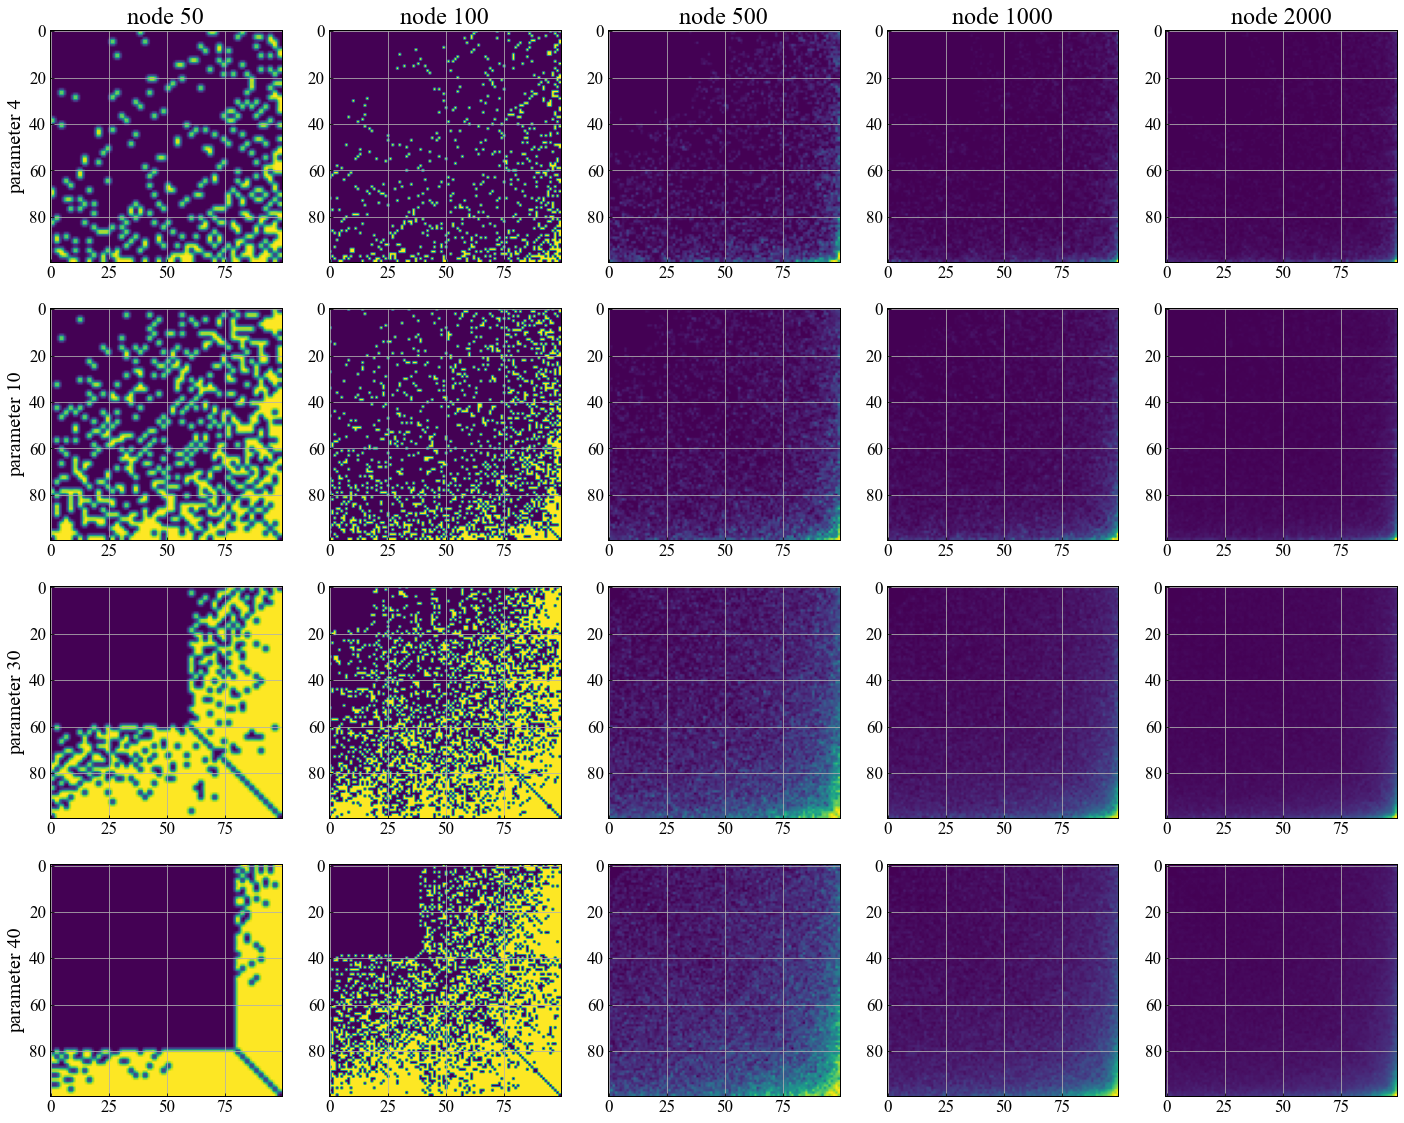

In [40]:
fig, axes = plt.subplots(4,5,figsize=(20,16))

for row, parameter in enumerate([4, 10, 30, 40]):
    for column, node in enumerate([50, 100, 500, 1000,2000]):
        G = nx.barabasi_albert_graph(node, parameter)
        img = network_to_image(G, sort=True)
        axes[row, column].imshow(img.resize((100,100)))
        if row == 0:
            axes[row, column].set_title(f"node {node}")
        if column == 0:
            axes[row, column].set_ylabel(f"parameter {parameter}")

plt.tight_layout()

In [30]:
G = nx.barabasi_albert_graph(1000, 2)

In [31]:
sub_G = G.subgraph(np.random.choice(range(1000), size=200, replace=False))

In [32]:
A = nx.to_numpy_array(sub_G)

In [33]:
sub_G_relabel = nx.relabel_nodes(sub_G, {n: i for i,n in enumerate(list(sub_G.nodes))})

In [34]:
sub_img = network_to_image(sub_G_relabel, sort=True)

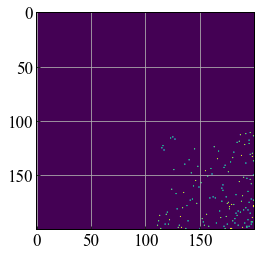

In [35]:
plt.imshow(sub_img)

# train log EDA

In [ ]:
df = pd.read_csv("../logs/subset1/CNN/")